<a href="https://colab.research.google.com/github/william94000schr/PIE_MSXS_02/blob/main/Pipeline2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des librairies

In [2]:
import os
import shutil
# from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torchsummary import summary
import tqdm

import json

# Environnement

## Vérification GPU

In [3]:
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nombre de GPUs:", torch.cuda.device_count())
    print("Nom du GPU:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de: {device}")

CUDA disponible: True
Nombre de GPUs: 1
Nom du GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Utilisation de: cuda


## Environnement de travail & Choix du Dataset



In [4]:
# drive.mount('/content/drive')

In [5]:
import os

# Choix du dataset via une liste déroulante (Jupyter)

SELECTED_DATASET = 'SOC'
print(f"ipywidgets non disponible, dataset par défaut: {SELECTED_DATASET}")

# Detect if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Colab paths
    local_train_dir = f'/content/ATR-Code/datasets/MSTAR/MSTAR_IMG_JSON/{SELECTED_DATASET}/train'
    local_test_dir = f'/content/ATR-Code/datasets/MSTAR/MSTAR_IMG_JSON/{SELECTED_DATASET}/test'
else:
    # Local paths
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    dataset_root = os.path.join(project_root, 'datasets', 'MSTAR', 'MSTAR_IMG_JSON', SELECTED_DATASET)
    local_train_dir = os.path.join(dataset_root, 'train')
    local_test_dir = os.path.join(dataset_root, 'test')

print("Train dir:", local_train_dir)
print("Test dir:", local_test_dir)

ipywidgets non disponible, dataset par défaut: SOC
Train dir: /home/alexandre/Documents/PIE Code/ATR-Code/datasets/MSTAR/MSTAR_IMG_JSON/SOC/train
Test dir: /home/alexandre/Documents/PIE Code/ATR-Code/datasets/MSTAR/MSTAR_IMG_JSON/SOC/test


# Chargement des données

## Structure du Dataset & Parametric Study Parameters

This notebook performs a **parametric study** of the Lee filter's effect on CNN training:
- **Window sizes**: Different kernel sizes for the Lee filter (e.g., 3x3, 5x5, 7x7)
- **Noise variances**: Different assumed noise variance values

The study includes a baseline (no Lee filter) for comparison.

In [6]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

# ============================================================
# MEMORY USAGE CONFIGURATION
# ============================================================
USE_PATCH_AUGMENTATION = False  # Set to False to save RAM, True for patch augmentation
print(f"Patch augmentation: {'ENABLED' if USE_PATCH_AUGMENTATION else 'DISABLED (memory efficient)'}")

# Hyperparamètres - OPTIMIZED FOR SPEED AND MEMORY
IMAGE_SIZE = (94, 94)  # Changed from (16,16) to match CNN architecture
BATCH_SIZE = 32  # Increased from 32 for better GPU utilization
NUM_EPOCHS = 10
PATCH_SIZE = 94  # Patch size for augmentation (if enabled)
STRIDE = 1  # Stride for patch extraction (if enabled)
CHIP_SIZE = 100  # Changed from 20 to standard MSTAR chip size

# Mixed precision training for faster GPU computation
USE_MIXED_PRECISION = torch.cuda.is_available()  # Automatic mixed precision (AMP)
print(f"Mixed precision training: {'ENABLED' if USE_MIXED_PRECISION else 'DISABLED'}")

# ============================================================
# PARAMETRIC STUDY: Lee Filter Parameters
# ============================================================
# Define the parameter grid for the Lee filter study
# Set to [None] to include a "no filter" baseline
LEE_WINDOW_SIZES = [None, 3, 5, 7, 9]  # None = no Lee filter
LEE_NOISE_VARIANCES = [0, 0.01, 0.05, 0.1, 0.2]  # Different noise variance values

# Generate all combinations for the parametric study
from itertools import product

param_combinations = []
# Add baseline (no Lee filter)
param_combinations.append({'name': 'No_Lee', 'window_size': None, 'noise_variance': None})
# Add all Lee filter combinations
for ws, nv in product([w for w in LEE_WINDOW_SIZES if w is not None], LEE_NOISE_VARIANCES):
    param_combinations.append({
        'name': f'Lee_W{ws}_V{nv}',
        'window_size': ws,
        'noise_variance': nv
    })

print(f"Parametric Study: {len(param_combinations)} configurations to test")
for i, config in enumerate(param_combinations):
    print(f"  {i+1}. {config['name']}: window_size={config['window_size']}, noise_variance={config['noise_variance']}")

Patch augmentation: DISABLED (memory efficient)
Mixed precision training: ENABLED
Parametric Study: 21 configurations to test
  1. No_Lee: window_size=None, noise_variance=None
  2. Lee_W3_V0: window_size=3, noise_variance=0
  3. Lee_W3_V0.01: window_size=3, noise_variance=0.01
  4. Lee_W3_V0.05: window_size=3, noise_variance=0.05
  5. Lee_W3_V0.1: window_size=3, noise_variance=0.1
  6. Lee_W3_V0.2: window_size=3, noise_variance=0.2
  7. Lee_W5_V0: window_size=5, noise_variance=0
  8. Lee_W5_V0.01: window_size=5, noise_variance=0.01
  9. Lee_W5_V0.05: window_size=5, noise_variance=0.05
  10. Lee_W5_V0.1: window_size=5, noise_variance=0.1
  11. Lee_W5_V0.2: window_size=5, noise_variance=0.2
  12. Lee_W7_V0: window_size=7, noise_variance=0
  13. Lee_W7_V0.01: window_size=7, noise_variance=0.01
  14. Lee_W7_V0.05: window_size=7, noise_variance=0.05
  15. Lee_W7_V0.1: window_size=7, noise_variance=0.1
  16. Lee_W7_V0.2: window_size=7, noise_variance=0.2
  17. Lee_W9_V0: window_size=9, nois

Les différents jeux de données
- **Entraînement (train)** : Sert à apprendre au modèle les données.

- **Validation (val)** : Nous sert à ajuster les hyperparamètres du modèle (comme le nombre d'époques, les couches, etc.). En surveillant l'accuracy sur cet ensemble pendant l'entraînement, on peut détecter l'overfitting.

- **Test (test)** : Sert à évaluer la performance finale et réelle du modèle sur des données complètement neuves et jamais vues. C'est la seule mesure non biaisée de la généralisation du modèle.

``image_dataset_from_directory`` :

Cette fonction de Keras simplifie le processus de lecture des images. Elle déduit automatiquement les classes en se basant sur la structure de nos sous-dossiers. Elle effectue également le prétraitement essentiel en redimensionnant les images, en les convertissant en niveaux de gris (``grayscale``) et en préparant les étiquettes en format one-hot (``categorical``)...

Elle gère donc le chargement et l'uniformisation des données pour les rendre directement utilisables par le modèle CNN.

In [7]:
# Ajout du Lee Filter dans la pipeline de transformation
import sys
sys.path.append(os.path.join(project_root, 'src', 'data', 'MSTAR', 'Alex'))
from lee_filter import LeeFilterTransform

def create_transforms(window_size=None, noise_variance=None):
    """
    Creates transform pipelines for training and testing.
    If window_size is None, no Lee filter is applied.
    
    IMPORTANT: Lee filter is applied BEFORE resize to preserve its effects!
    """
    if window_size is None:
        # No Lee filter
        base_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
        test_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.CenterCrop(size=CHIP_SIZE),
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
        ])
    else:
        # With Lee filter - APPLIED BEFORE RESIZE!
        base_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            LeeFilterTransform(window_size=window_size, noise_variance=noise_variance),
        ])
        test_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.CenterCrop(size=CHIP_SIZE),
            transforms.ToTensor(),  # Convert to tensor first
            LeeFilterTransform(window_size=window_size, noise_variance=noise_variance),  # Apply Lee filter
            transforms.Lambda(lambda x: torch.nn.functional.interpolate(
                x.unsqueeze(0), size=IMAGE_SIZE, mode='bilinear', align_corners=False
            ).squeeze(0))  # Then resize
        ])
    return base_transform, test_transform

print("Transform factory function created.")
print("Use create_transforms(window_size, noise_variance) to generate transforms for each configuration.")
print("⚠️  Lee filter is now applied BEFORE resize for better effectiveness!")

Transform factory function created.
Use create_transforms(window_size, noise_variance) to generate transforms for each configuration.
⚠️  Lee filter is now applied BEFORE resize for better effectiveness!


In [8]:
print("\n" + "="*60)
print("LOADING BASE DATASET FOR SPLIT INDICES")
print("="*60)

# Load dataset once with basic transform to get class info and split indices
basic_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

full_train_dataset_base = ImageFolder(root=local_train_dir, transform=basic_transform)

# Informations sur les classes
class_names = full_train_dataset_base.classes
num_classes = len(class_names)
print(f"\nClasses ({num_classes}) : {class_names}")

# Split 80/20 sur les IMAGES - Get indices once for consistency
train_size = int(0.8 * len(full_train_dataset_base))
val_size = len(full_train_dataset_base) - train_size

generator = torch.Generator().manual_seed(SEED)
indices = torch.randperm(len(full_train_dataset_base), generator=generator).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

print(f"\nSplit sur images :")
print(f"  Train : {len(train_indices)} images")
print(f"  Val   : {len(val_indices)} images")
print(f"\nThese indices will be reused for all parameter configurations to ensure fair comparison.")


LOADING BASE DATASET FOR SPLIT INDICES

Classes (10) : ['2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70', 'D7', 'T62', 'T72', 'ZIL131', 'ZSU234']

Split sur images :
  Train : 2197 images
  Val   : 550 images

These indices will be reused for all parameter configurations to ensure fair comparison.


In [9]:
def extract_patches_from_tensor(image_tensor, patch_size, stride, chip_size):
    """
    Extrait les patches 94x94 avec stride=1 après rognage à 100x100.
    Fidèle au protocole MSTAR.
    """
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)

    # Rogne au centre à 100x100 (chip_size)
    if image_tensor.size(2) > chip_size:
        start = (image_tensor.size(2) - chip_size) // 2
        image_tensor = image_tensor[:, :, start:start + chip_size, start:start + chip_size]

    # Extraction des patches avec F.unfold
    patches_unfold = F.unfold(
        image_tensor,
        kernel_size=patch_size,
        stride=stride
    )

    # Remise en forme (N_patches, C, H, W)
    C = image_tensor.size(1)
    patches = patches_unfold.transpose(1, 2)
    patches = patches.reshape(-1, C, patch_size, patch_size)

    return patches


In [10]:
class AugmentedDataset(Dataset):
    """Dataset contenant les patches augmentés"""
    def __init__(self, augmented_data):
        self.data = augmented_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def augment_dataset_with_patches(dataset, patch_size, stride, chip_size, desc="Extraction"):
    """
    Applique l'augmentation par patches sur un dataset.
    Chaque image génère 169 patches (13x13).
    """
    augmented_samples = []

    # DataLoader temporaire
    temp_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    for images, labels in tqdm.tqdm(temp_loader, desc=desc):
        images_squeeze = images.squeeze(0)
        patches = extract_patches_from_tensor(
            images_squeeze,
            patch_size=patch_size,
            stride=stride,
            chip_size=chip_size
        )

        label = labels.item()
        for patch in patches:
            augmented_samples.append((patch, label))

    return augmented_samples

def prepare_data_for_config(config, train_indices, val_indices, local_train_dir, local_test_dir):
    """
    Prepare train, validation, and test data for a specific Lee filter configuration.
    Returns: train_loader, val_loader, test_loader, train_dataset, test_dataset
    """
    base_transform, test_transform = create_transforms(
        config['window_size'], 
        config['noise_variance']
    )
    
    # Load full dataset with config-specific transform
    full_train_dataset = ImageFolder(root=local_train_dir, transform=base_transform)
    
    # Create subsets using the same indices
    train_subset = torch.utils.data.Subset(full_train_dataset, train_indices)
    val_subset = torch.utils.data.Subset(full_train_dataset, val_indices)
    
    # Augment with patches
    print(f"\n  Augmenting train set for {config['name']}...")
    train_augmented = augment_dataset_with_patches(
        train_subset, PATCH_SIZE, STRIDE, CHIP_SIZE, 
        desc=f"Train patches {config['name']}"
    )
    
    print(f"  Augmenting val set for {config['name']}...")
    val_augmented = augment_dataset_with_patches(
        val_subset, PATCH_SIZE, STRIDE, CHIP_SIZE,
        desc=f"Val patches {config['name']}"
    )
    
    # Create datasets
    train_dataset = AugmentedDataset(train_augmented)
    val_dataset = AugmentedDataset(val_augmented)
    test_dataset = ImageFolder(root=local_test_dir, transform=test_transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=2, pin_memory=True if torch.cuda.is_available() else False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=2, pin_memory=True if torch.cuda.is_available() else False
    )
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=2, pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"  {config['name']}: {len(train_augmented)} train patches, {len(val_augmented)} val patches, {len(test_dataset)} test images")
    
    return train_loader, val_loader, test_loader, train_dataset, test_dataset

print("Data preparation functions defined.")

Data preparation functions defined.


In [11]:
# =============================================================================
# MEMORY-EFFICIENT VERSION - NO PATCH AUGMENTATION
# =============================================================================

class SimpleDataset(Dataset):
    """Simple dataset wrapper without patch augmentation to save RAM"""
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]

def prepare_data_for_config_no_augmentation(config, train_indices, val_indices, local_train_dir, local_test_dir):
    """
    Memory-efficient data preparation WITHOUT patch augmentation.
    Uses original images directly with transforms applied on-the-fly.
    
    IMPORTANT: Lee filter is applied BEFORE resize!
    """
    base_transform, test_transform = create_transforms(
        config['window_size'], 
        config['noise_variance']
    )
    
    # Enhanced transforms for training data - Lee filter BEFORE resize
    if config['window_size'] is None:
        train_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.CenterCrop(size=CHIP_SIZE),
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.CenterCrop(size=CHIP_SIZE),
            transforms.ToTensor(),  # Convert to tensor first
            LeeFilterTransform(window_size=config['window_size'], noise_variance=config['noise_variance']),  # Apply Lee filter
            transforms.Lambda(lambda x: torch.nn.functional.interpolate(
                x.unsqueeze(0), size=IMAGE_SIZE, mode='bilinear', align_corners=False
            ).squeeze(0))  # Then resize
        ])
    
    # Load full dataset with config-specific transform
    full_train_dataset = ImageFolder(root=local_train_dir, transform=train_transform)
    
    # Create subsets using the same indices
    train_subset = torch.utils.data.Subset(full_train_dataset, train_indices)
    val_subset = torch.utils.data.Subset(full_train_dataset, val_indices)
    
    # Create simple datasets (no augmentation)
    train_dataset = SimpleDataset(train_subset)
    val_dataset = SimpleDataset(val_subset)
    test_dataset = ImageFolder(root=local_test_dir, transform=test_transform)
    
    # OPTIMIZED: num_workers=4 for faster data loading, persistent_workers=True to reuse workers
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=4, pin_memory=True if torch.cuda.is_available() else False,
        persistent_workers=True, prefetch_factor=2
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=4, pin_memory=True if torch.cuda.is_available() else False,
        persistent_workers=True, prefetch_factor=2
    )
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=4, pin_memory=True if torch.cuda.is_available() else False,
        persistent_workers=True, prefetch_factor=2
    )
    
    print(f"  {config['name']} (NO AUGMENTATION): {len(train_subset)} train images, {len(val_subset)} val images, {len(test_dataset)} test images")
    
    return train_loader, val_loader, test_loader, train_dataset, test_dataset

print("Memory-efficient data preparation functions defined (no patch augmentation).")
print("⚠️  Lee filter is now applied BEFORE resize for better effectiveness!")

Memory-efficient data preparation functions defined (no patch augmentation).
⚠️  Lee filter is now applied BEFORE resize for better effectiveness!


# Memory Usage Comparison

**Two modes are available:**

## 1. Patch Augmentation Mode (`USE_PATCH_AUGMENTATION = True`)
- **Memory Usage**: Very High (169x more data per image)
- **Training data**: Each 100x100 image → 169 patches of 94x94 
- **Benefits**: More training samples, potentially better generalization
- **Drawbacks**: Requires significant RAM (~10-20GB+ for full dataset)

## 2. Memory Efficient Mode (`USE_PATCH_AUGMENTATION = False`) 
- **Memory Usage**: Low (uses original images only)
- **Training data**: Direct use of 94x94 center-cropped images
- **Benefits**: Low RAM usage, faster data loading
- **Drawbacks**: Fewer training samples per image

**Recommendation**: Start with `USE_PATCH_AUGMENTATION = False` for initial experiments and parameter tuning, then switch to `True` for final training if you have sufficient RAM.

In [12]:
# Storage for all results
all_results = {}

print("\n" + "="*60)
print("PARAMETRIC STUDY: DATA PREPARATION")
print("="*60)

# Prepare data for all configurations
data_loaders = {}
for config in param_combinations:
    print(f"\nPreparing data for: {config['name']}")
    
    if USE_PATCH_AUGMENTATION:
        # Original memory-intensive method with patch augmentation
        train_loader, val_loader, test_loader, train_dataset, test_dataset = prepare_data_for_config(
            config, train_indices, val_indices, local_train_dir, local_test_dir
        )
    else:
        # Memory-efficient method without patch augmentation
        train_loader, val_loader, test_loader, train_dataset, test_dataset = prepare_data_for_config_no_augmentation(
            config, train_indices, val_indices, local_train_dir, local_test_dir
        )
    
    data_loaders[config['name']] = {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'test_dataset': test_dataset,
        'config': config
    }

print("\n" + "="*60)
print(f"Data prepared for {len(data_loaders)} configurations")
print(f"Memory mode: {'Patch Augmentation ENABLED' if USE_PATCH_AUGMENTATION else 'Memory Efficient (NO patch augmentation)'}")
print("="*60)


PARAMETRIC STUDY: DATA PREPARATION

Preparing data for: No_Lee
  No_Lee (NO AUGMENTATION): 2197 train images, 550 val images, 2425 test images

Preparing data for: Lee_W3_V0
  Lee_W3_V0 (NO AUGMENTATION): 2197 train images, 550 val images, 2425 test images

Preparing data for: Lee_W3_V0.01
  Lee_W3_V0.01 (NO AUGMENTATION): 2197 train images, 550 val images, 2425 test images

Preparing data for: Lee_W3_V0.05
  Lee_W3_V0.05 (NO AUGMENTATION): 2197 train images, 550 val images, 2425 test images

Preparing data for: Lee_W3_V0.1
  Lee_W3_V0.1 (NO AUGMENTATION): 2197 train images, 550 val images, 2425 test images

Preparing data for: Lee_W3_V0.2
  Lee_W3_V0.2 (NO AUGMENTATION): 2197 train images, 550 val images, 2425 test images

Preparing data for: Lee_W5_V0
  Lee_W5_V0 (NO AUGMENTATION): 2197 train images, 550 val images, 2425 test images

Preparing data for: Lee_W5_V0.01
  Lee_W5_V0.01 (NO AUGMENTATION): 2197 train images, 550 val images, 2425 test images

Preparing data for: Lee_W5_V0.0


VISUALIZING LEE FILTER EFFECTS ON SAME IMAGE
Window sizes: [3, 5, 7, 9]
Noise variances: [0, 0.01, 0.05, 0.1, 0.2]


/tmp/ipykernel_27028/1385088171.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


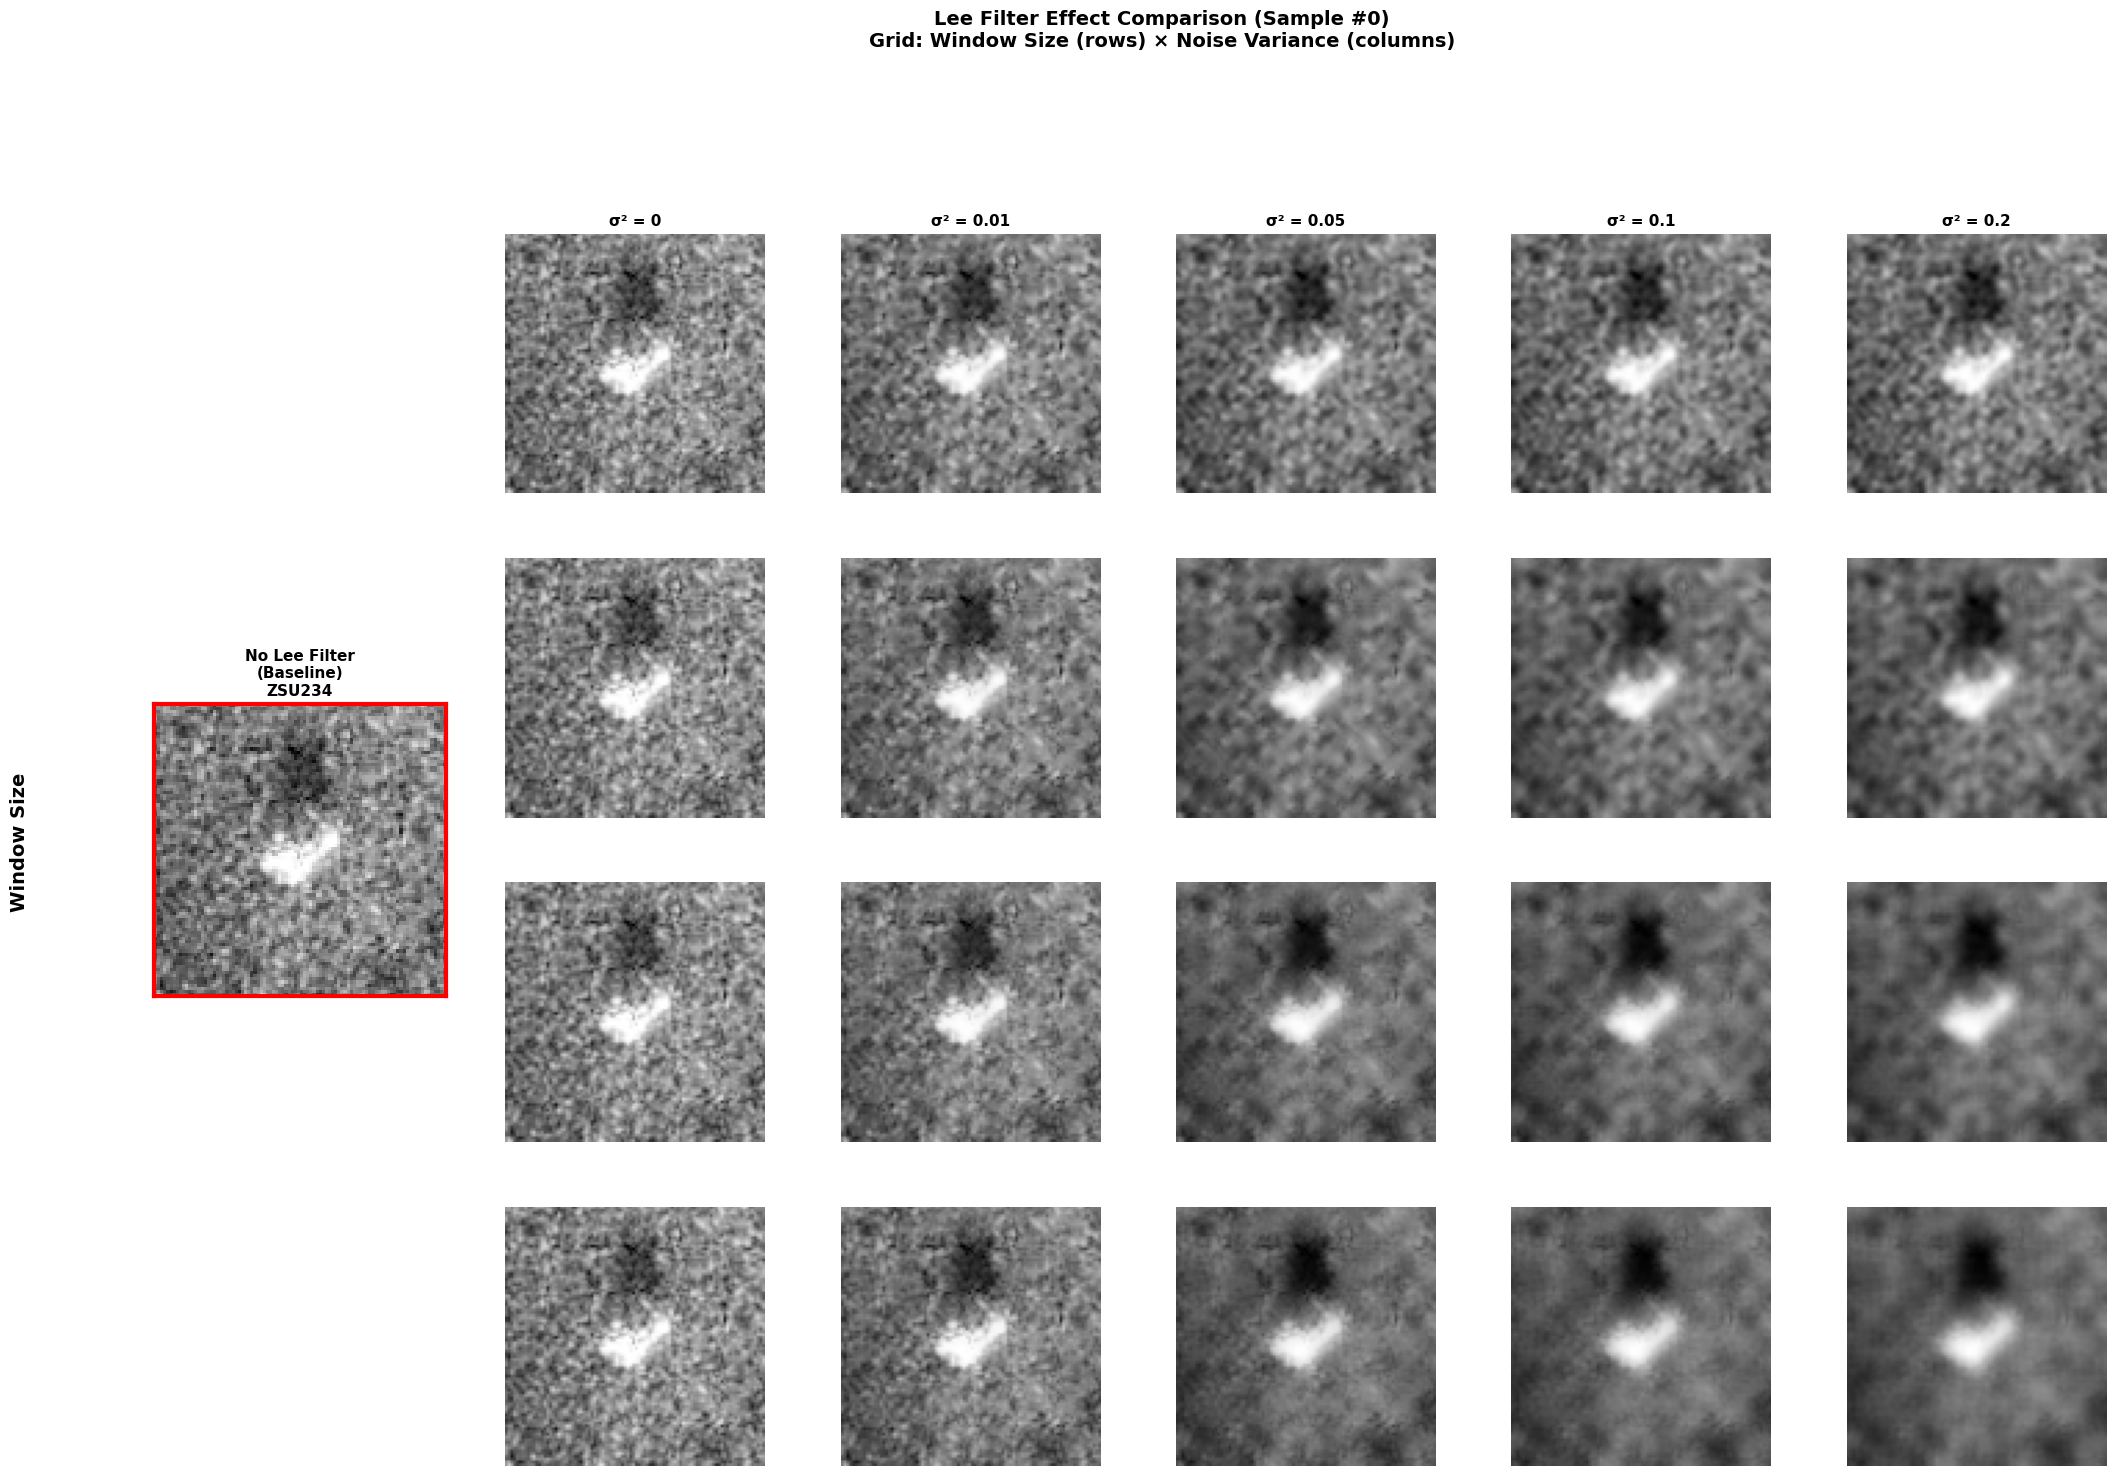


DETAILED COMPARISON: 3 SAMPLES x ALL CONFIGURATIONS


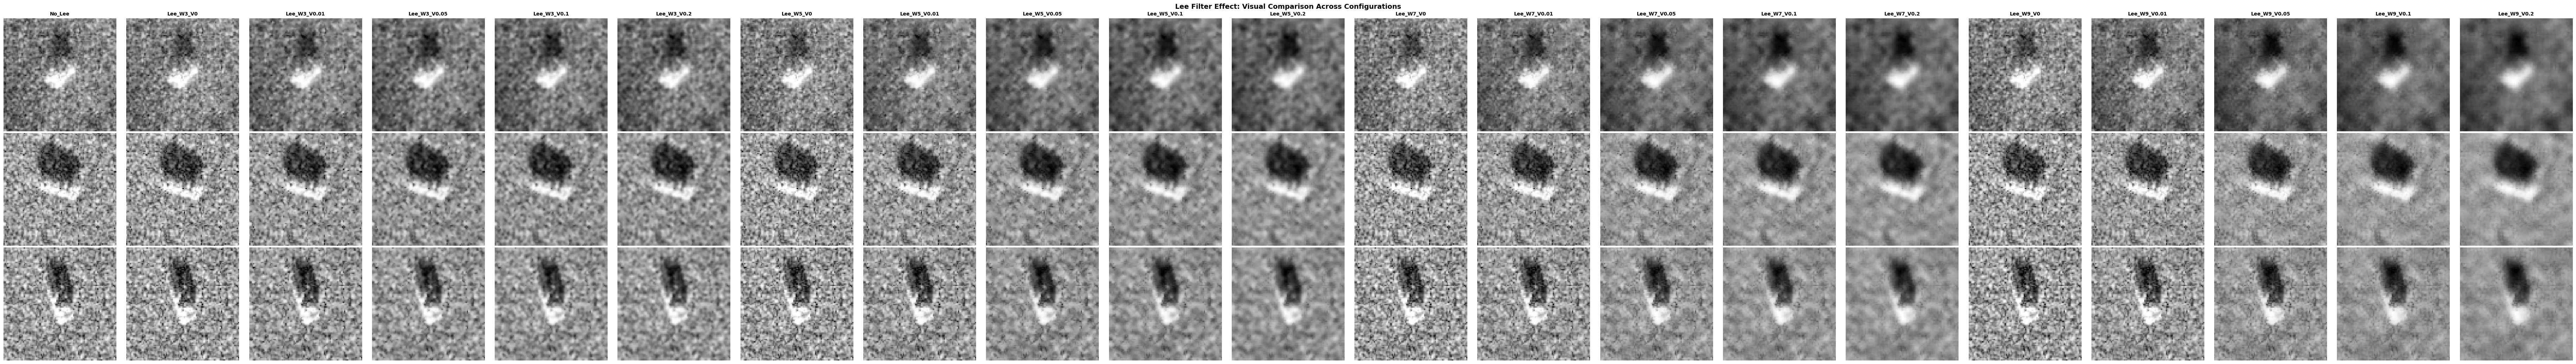


PIXEL INTENSITY DISTRIBUTION COMPARISON


/tmp/ipykernel_27028/1385088171.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


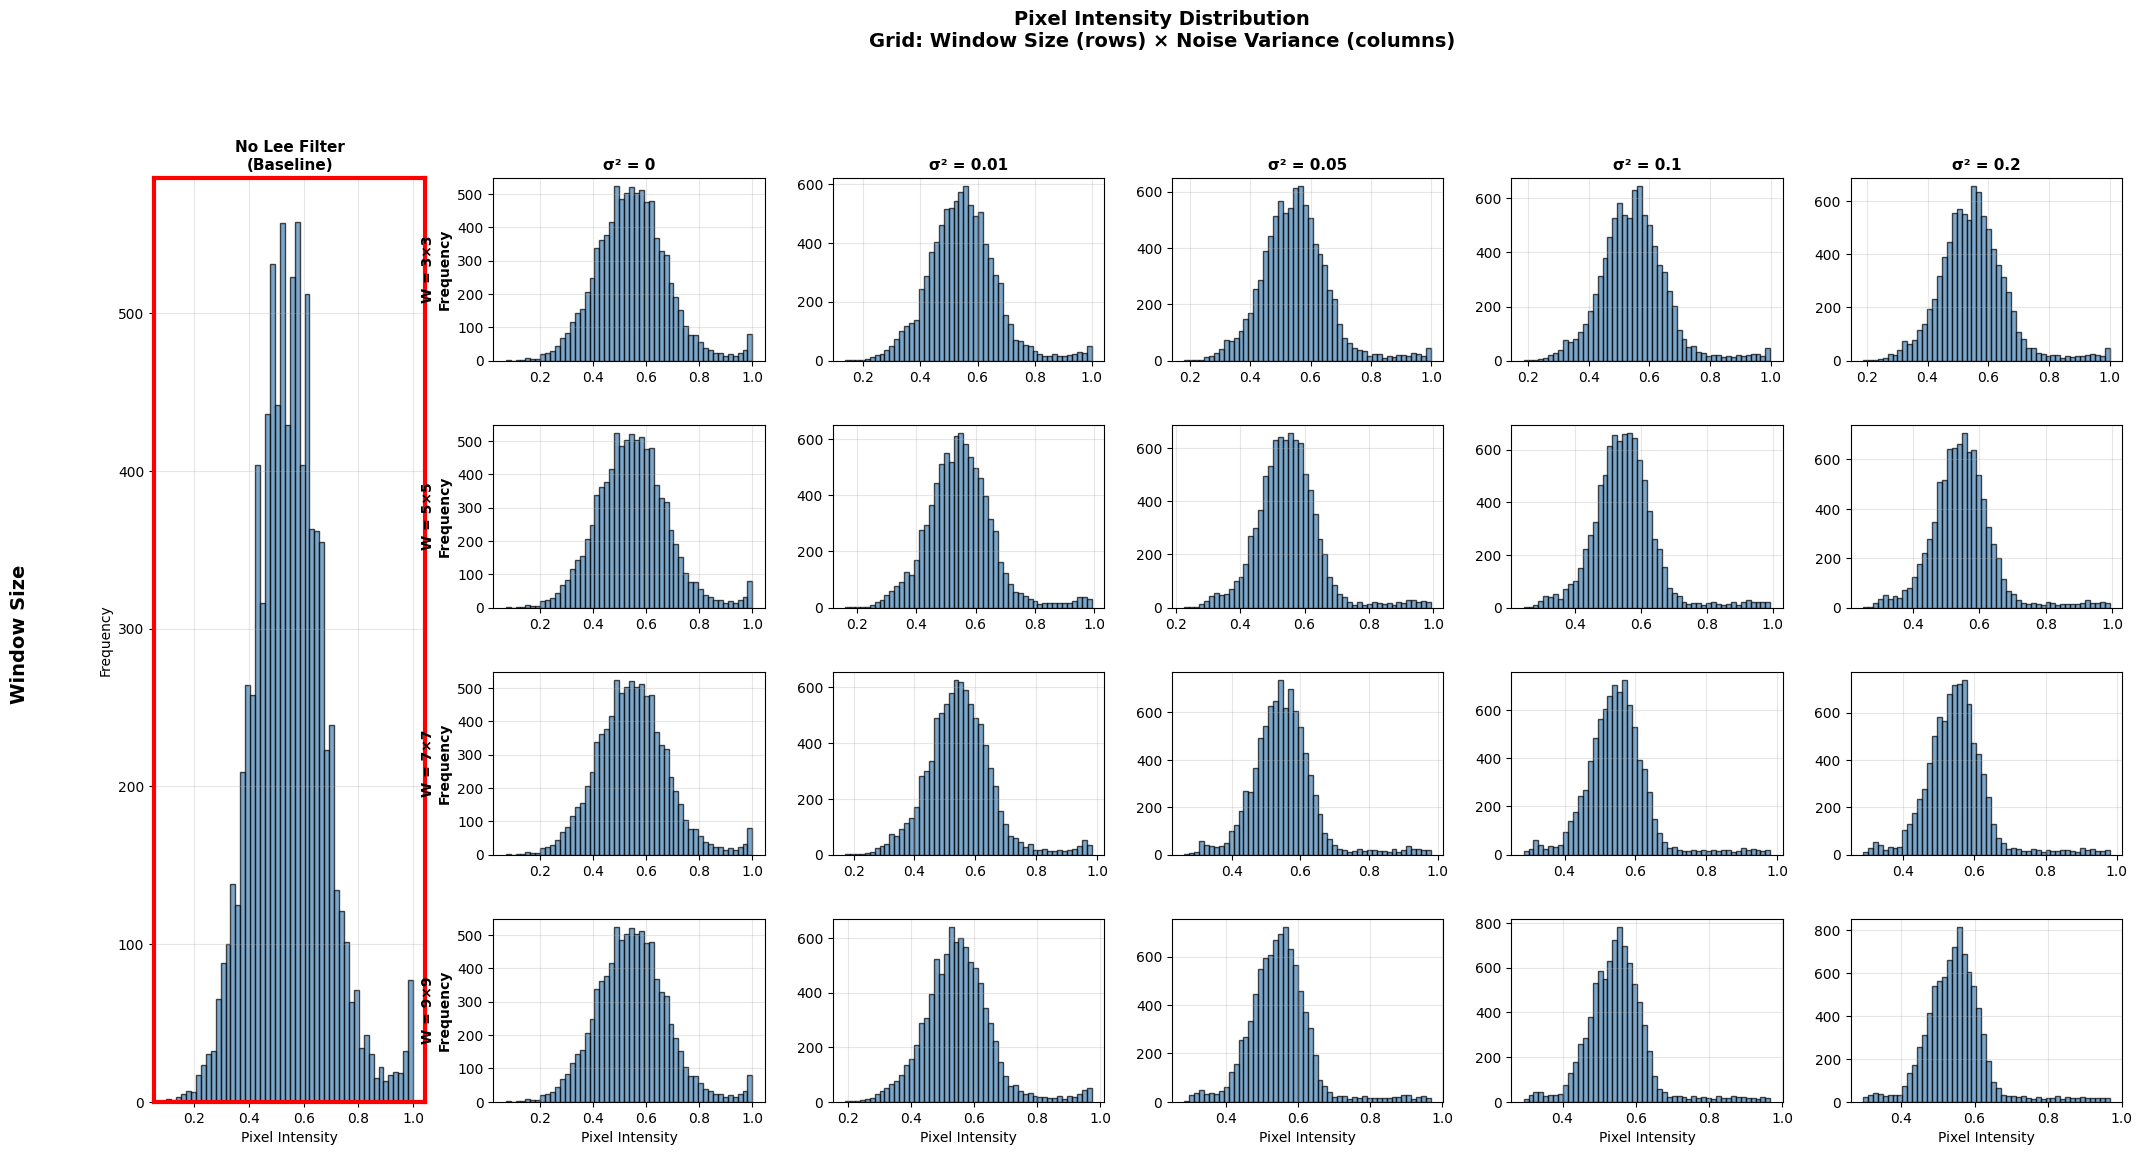


✅ Visualization complete!


In [13]:
# ============================================================
# VISUALIZE LEE FILTER EFFECTS: GRID (Window Size x Noise Variance)
# ============================================================

print("\n" + "="*70)
print("VISUALIZING LEE FILTER EFFECTS ON SAME IMAGE")
print("="*70)

# Get a sample image index to compare across configurations
sample_idx = 0  # Use first image for consistency

# Get unique window sizes and noise variances from configurations
window_sizes = sorted(set(c['window_size'] for c in param_combinations if c['window_size'] is not None))
noise_variances = sorted(set(c['noise_variance'] for c in param_combinations if c['noise_variance'] is not None))

print(f"Window sizes: {window_sizes}")
print(f"Noise variances: {noise_variances}")

# Create figure: main grid + baseline aside
# Layout: baseline on left, then grid of (window_size x noise_variance)
fig = plt.figure(figsize=(4 * (len(noise_variances) + 1), 4 * len(window_sizes)))

# Create grid spec: 1 column for baseline + len(noise_variances) columns for Lee filter
gs = fig.add_gridspec(len(window_sizes), len(noise_variances) + 1, 
                       width_ratios=[1] + [1] * len(noise_variances),
                       wspace=0.15, hspace=0.25)

# Plot baseline (No Lee filter) - spans all rows in first column
if 'No_Lee' in data_loaders:
    # Create a merged axis for baseline (center vertically)
    ax_baseline = fig.add_subplot(gs[:, 0])
    sample_image, sample_label = data_loaders['No_Lee']['train_dataset'][sample_idx]
    if isinstance(sample_image, torch.Tensor):
        img_np = sample_image.squeeze().cpu().numpy()
    else:
        img_np = sample_image
    ax_baseline.imshow(img_np, cmap='gray')
    ax_baseline.set_title(f"No Lee Filter\n(Baseline)\n{class_names[sample_label]}", fontsize=11, fontweight='bold')
    # Add red border around baseline
    for spine in ax_baseline.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(3)
        spine.set_visible(True)
    ax_baseline.set_xticks([])
    ax_baseline.set_yticks([])

# Plot Lee filter grid
for row_idx, ws in enumerate(window_sizes):
    for col_idx, nv in enumerate(noise_variances):
        config_name = f'Lee_W{ws}_V{nv}'
        if config_name in data_loaders:
            ax = fig.add_subplot(gs[row_idx, col_idx + 1])  # +1 to skip baseline column
            sample_image, sample_label = data_loaders[config_name]['train_dataset'][sample_idx]
            
            if isinstance(sample_image, torch.Tensor):
                img_np = sample_image.squeeze().cpu().numpy()
            else:
                img_np = sample_image
            
            ax.imshow(img_np, cmap='gray')
            
            # Add titles: noise variance on top row, window size on leftmost Lee column
            if row_idx == 0:
                ax.set_title(f"σ² = {nv}", fontsize=11, fontweight='bold')
            if col_idx == 0:
                ax.set_ylabel(f"W = {ws}×{ws}", fontsize=11, fontweight='bold')
            ax.axis('off')

# Add y-axis label for Window Size
fig.text(0.02, 0.5, 'Window Size', va='center', rotation='vertical', fontsize=14, fontweight='bold')

# Add overall title and axis labels
fig.suptitle(f"Lee Filter Effect Comparison (Sample #{sample_idx})\nGrid: Window Size (rows) × Noise Variance (columns)", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(left=0.08)  # Make room for y-axis label
plt.show()

# ============================================================
# DETAILED COMPARISON: Multiple samples in a grid
# ============================================================

print("\n" + "="*70)
print("DETAILED COMPARISON: 3 SAMPLES x ALL CONFIGURATIONS")
print("="*70)

# Compare 3 different samples
sample_indices = [0, 10, 20]  # Adjust based on dataset size
num_samples = len(sample_indices)
num_configs = len(data_loaders)

fig, axes = plt.subplots(num_samples, num_configs, figsize=(3.5 * num_configs, 3.5 * num_samples))

for row, sample_idx in enumerate(sample_indices):
    for col, (config_name, data) in enumerate(data_loaders.items()):
        ax = axes[row, col] if num_samples > 1 else axes[col]
        
        # Get sample
        try:
            sample_image, sample_label = data['train_dataset'][sample_idx]
            
            # Convert to numpy
            if isinstance(sample_image, torch.Tensor):
                img_np = sample_image.squeeze().cpu().numpy()
            else:
                img_np = sample_image
            
            ax.imshow(img_np, cmap='gray')
            
            # Title: config name on top row, class name on all
            if row == 0:
                ax.set_title(f"{config_name}", fontsize=10, fontweight='bold')
            ax.set_ylabel(f"Sample {sample_idx}\n({class_names[sample_label]})" if col == 0 else "", fontsize=9)
        except IndexError:
            ax.text(0.5, 0.5, "N/A", ha='center', va='center', transform=ax.transAxes)
        
        ax.axis('off')

plt.suptitle("Lee Filter Effect: Visual Comparison Across Configurations", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================
# PIXEL INTENSITY HISTOGRAM: GRID (Window Size x Noise Variance)
# ============================================================

print("\n" + "="*70)
print("PIXEL INTENSITY DISTRIBUTION COMPARISON")
print("="*70)

# Create figure: baseline aside + grid layout
fig = plt.figure(figsize=(4 * (len(noise_variances) + 1), 3 * len(window_sizes)))

gs = fig.add_gridspec(len(window_sizes), len(noise_variances) + 1, 
                       width_ratios=[1] + [1] * len(noise_variances),
                       wspace=0.25, hspace=0.35)

# Plot baseline histogram - spans all rows in first column
if 'No_Lee' in data_loaders:
    ax_baseline = fig.add_subplot(gs[:, 0])
    sample_image, _ = data_loaders['No_Lee']['train_dataset'][0]
    if isinstance(sample_image, torch.Tensor):
        img_np = sample_image.squeeze().cpu().numpy()
    else:
        img_np = sample_image
    ax_baseline.hist(img_np.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax_baseline.set_title("No Lee Filter\n(Baseline)", fontsize=11, fontweight='bold')
    ax_baseline.set_xlabel("Pixel Intensity")
    ax_baseline.set_ylabel("Frequency")
    ax_baseline.grid(True, alpha=0.3)
    # Add red border around baseline
    for spine in ax_baseline.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(3)

# Plot Lee filter histograms in grid
for row_idx, ws in enumerate(window_sizes):
    for col_idx, nv in enumerate(noise_variances):
        config_name = f'Lee_W{ws}_V{nv}'
        if config_name in data_loaders:
            ax = fig.add_subplot(gs[row_idx, col_idx + 1])
            sample_image, _ = data_loaders[config_name]['train_dataset'][0]
            
            if isinstance(sample_image, torch.Tensor):
                img_np = sample_image.squeeze().cpu().numpy()
            else:
                img_np = sample_image
            
            ax.hist(img_np.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
            
            # Add titles
            if row_idx == 0:
                ax.set_title(f"σ² = {nv}", fontsize=11, fontweight='bold')
            if col_idx == 0:
                ax.set_ylabel(f"W = {ws}×{ws}\nFrequency", fontsize=10, fontweight='bold')
            else:
                ax.set_ylabel("")
            if row_idx == len(window_sizes) - 1:
                ax.set_xlabel("Pixel Intensity")
            ax.grid(True, alpha=0.3)

# Add y-axis label for Window Size
fig.text(0.02, 0.5, 'Window Size', va='center', rotation='vertical', fontsize=14, fontweight='bold')

fig.suptitle("Pixel Intensity Distribution\nGrid: Window Size (rows) × Noise Variance (columns)", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(left=0.08)  # Make room for y-axis label
plt.show()

print("\n✅ Visualization complete!")

**Pourquoi travailler par lots (batches) ?**

Travailler par lots signifie traiter plusieurs images en même temps plutôt qu'une seule à la fois. Cette approche présente trois avantages majeurs :

- **Efficacité mémoire** : Charger toutes les images en mémoire d'un coup est impossible (trop lourd). Les lots permettent de ne charger qu'un petit groupe d'images à la fois.

- **Vitesse de calcul** : Les GPU sont optimisés pour traiter plusieurs données simultanément. Un lot de 32 images est traité presque aussi vite qu'une seule image, ce qui accélère considérablement l'entraînement.

- **Meilleure généralisation** : Calculer le gradient (la direction de mise à jour des poids) sur un lot d'images plutôt que sur une seule donne une estimation plus stable et robuste, ce qui aide le modèle à mieux apprendre.

Le `batch_size=32` signifie donc que notre modèle traite 32 images à chaque itération avant de mettre à jour ses poids.

## Caractéristiques du dataset

In [14]:
def visualize_samples(dataset, class_names, num_samples=10, title="Échantillons"):
    """
    Affiche des échantillons aléatoires du dataset.
    """
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    # Sélectionne des indices aléatoires
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx, ax in zip(indices, axes.flat):
        image, label = dataset[idx]

        # Conversion tensor → numpy
        if isinstance(image, torch.Tensor):
            image = image.squeeze().cpu().numpy()

        ax.imshow(image, cmap='gray')
        ax.set_title(f"{class_names[label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("VISUALISATION DES DONNÉES")
print("="*60)
print("\nVisualization function defined. Samples will be shown after data preparation.")


VISUALISATION DES DONNÉES

Visualization function defined. Samples will be shown after data preparation.



DISTRIBUTION DES CLASSES

Ensemble d'ENTRAÎNEMENT (avant augmentation) :
  TOTAL : 2197
  2S1        :  237
  BMP2       :  196
  BRDM2      :  240
  BTR60      :  198
  BTR70      :  187
  D7         :  247
  T62        :  239
  T72        :  185
  ZIL131     :  229
  ZSU234     :  239

Ensemble de VALIDATION (avant augmentation) :
  TOTAL : 550
  2S1        :   62
  BMP2       :   37
  BRDM2      :   58
  BTR60      :   58
  BTR70      :   46
  D7         :   52
  T62        :   60
  T72        :   47
  ZIL131     :   70
  ZSU234     :   60

Ensemble de TEST :
  TOTAL : 2425
  2S1        :  274
  BMP2       :  195
  BRDM2      :  274
  BTR60      :  195
  BTR70      :  196
  D7         :  274
  T62        :  273
  T72        :  196
  ZIL131     :  274
  ZSU234     :  274


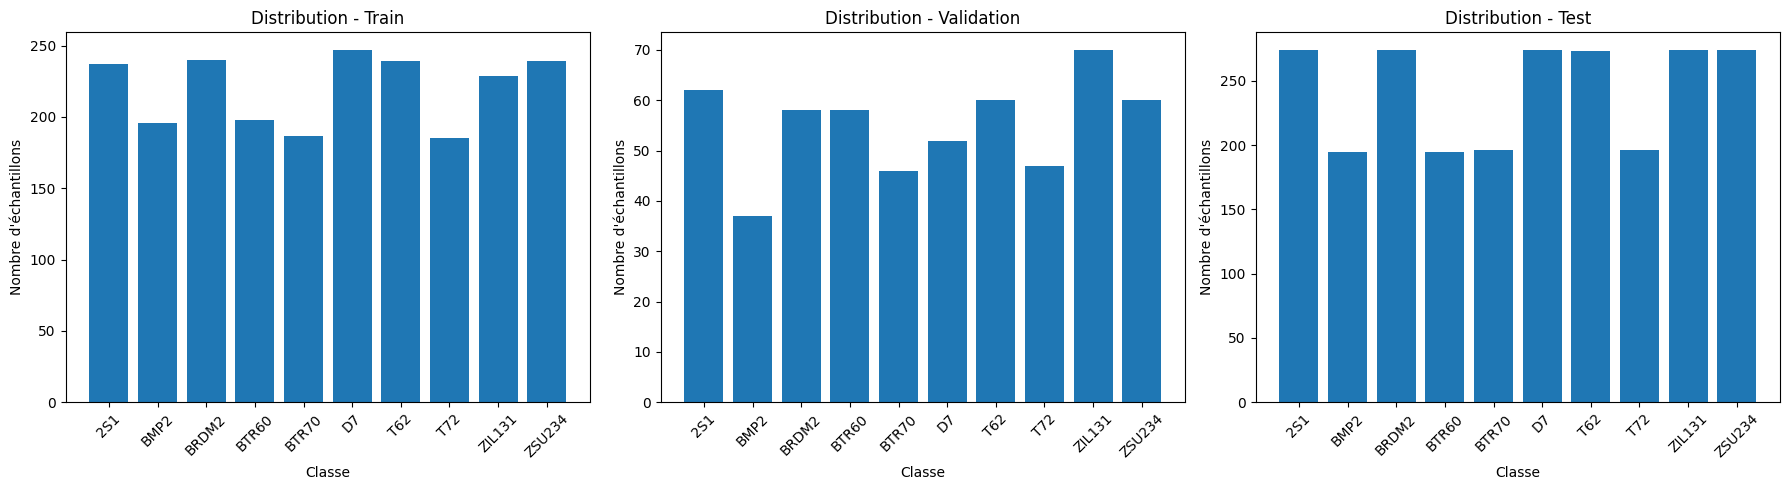

In [15]:
def count_samples_per_class(dataset, class_names):
    """
    Compte le nombre d'échantillons par classe.
    """
    class_counts = np.zeros(len(class_names), dtype=int)

    # Pour les sous-ensembles créés avec random_split
    if hasattr(dataset, 'dataset') and hasattr(dataset, 'indices'):
        for idx in dataset.indices:
            _, label = dataset.dataset[idx]
            class_counts[label] += 1
    else:
        # Pour les datasets complets ou custom
        for _, label in dataset:
            class_counts[label] += 1

    return class_counts

print("\n" + "="*60)
print("DISTRIBUTION DES CLASSES")
print("="*60)

# Count from base dataset using indices
print("\nEnsemble d'ENTRAÎNEMENT (avant augmentation) :")
train_counts = np.zeros(num_classes, dtype=int)
for idx in train_indices:
    _, label = full_train_dataset_base[idx]
    train_counts[label] += 1
print(f"  TOTAL : {np.sum(train_counts)}")
for i, class_name in enumerate(class_names):
    print(f"  {class_name:10s} : {train_counts[i]:4d}")

print("\nEnsemble de VALIDATION (avant augmentation) :")
val_counts = np.zeros(num_classes, dtype=int)
for idx in val_indices:
    _, label = full_train_dataset_base[idx]
    val_counts[label] += 1
print(f"  TOTAL : {np.sum(val_counts)}")
for i, class_name in enumerate(class_names):
    print(f"  {class_name:10s} : {val_counts[i]:4d}")

# Load test dataset to count
test_dataset_temp = ImageFolder(root=local_test_dir, transform=basic_transform)
print("\nEnsemble de TEST :")
test_counts = count_samples_per_class(test_dataset_temp, class_names)
print(f"  TOTAL : {np.sum(test_counts)}")
for i, class_name in enumerate(class_names):
    print(f"  {class_name:10s} : {test_counts[i]:4d}")

# Graphique de distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, counts, title in zip(axes,
                              [train_counts, val_counts, test_counts],
                              ['Train', 'Validation', 'Test']):
    ax.bar(class_names, counts)
    ax.set_title(f'Distribution - {title}')
    ax.set_xlabel('Classe')
    ax.set_ylabel("Nombre d'échantillons")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Préparation des données pour le modèle




# Modèle

## Architecture du CNN

In [16]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=1):
        super(CNN, self).__init__()

        # OPTIMIZED: Reduced channels for faster computation and less memory
        # Conv1: in_channels → 16 channels, 5x5, ReLU, MaxPool
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=0)
        self.bn1 = nn.BatchNorm2d(16)  # Added BatchNorm for faster convergence
        self.relu1 = nn.ReLU(inplace=True)  # inplace=True saves memory
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv2: 16 → 32 channels, 5x5, ReLU, MaxPool
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3: 32 → 64 channels, 6x6, ReLU, MaxPool
        self.conv3 = nn.Conv2d(32, 64, kernel_size=6, padding=0)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv4: 64 → 128 channels, 5x5, ReLU, Dropout
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)

        # Conv5: 128 → num_classes channels, 3x3
        self.conv5 = nn.Conv2d(128, num_classes, kernel_size=3, padding=0)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.dropout(self.relu4(self.bn4(self.conv4(x))))
        x = self.conv5(x)
        x = self.gap(x)
        x = self.flatten(x)
        return x

print("\n" + "="*60)
print("ARCHITECTURE DU MODÈLE (OPTIMIZED)")
print("="*60)

model = CNN(num_classes, in_channels=1).to(device)
print(summary(model, (1, 94, 94)))
print("\nOptimizations:")
print("  ✓ BatchNorm added for faster convergence")
print("  ✓ ReLU inplace operations for memory efficiency")
print("  ✓ Optimized for 94x94 input images")


ARCHITECTURE DU MODÈLE (OPTIMIZED)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 90, 90]             416
       BatchNorm2d-2           [-1, 16, 90, 90]              32
              ReLU-3           [-1, 16, 90, 90]               0
         MaxPool2d-4           [-1, 16, 45, 45]               0
            Conv2d-5           [-1, 32, 41, 41]          12,832
       BatchNorm2d-6           [-1, 32, 41, 41]              64
              ReLU-7           [-1, 32, 41, 41]               0
         MaxPool2d-8           [-1, 32, 20, 20]               0
            Conv2d-9           [-1, 64, 15, 15]          73,792
      BatchNorm2d-10           [-1, 64, 15, 15]             128
             ReLU-11           [-1, 64, 15, 15]               0
        MaxPool2d-12             [-1, 64, 7, 7]               0
           Conv2d-13            [-1, 128, 3, 3]         204,928
   

## Compilation & Entraînement

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Mixed precision scaler for faster training
scaler = torch.cuda.amp.GradScaler() if USE_MIXED_PRECISION else None

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Entraîne le modèle pour une époque - OPTIMIZED with mixed precision"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # Faster than zero_grad()
        
        if USE_MIXED_PRECISION:
            # Mixed precision training
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Évalue le modèle sur un ensemble de validation - OPTIMIZED"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            if USE_MIXED_PRECISION:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

print("Training functions defined with optimizations:")
print("  ✓ Mixed precision support (AMP)")
print("  ✓ Non-blocking data transfers")
print("  ✓ Optimized gradient zeroing")

Training functions defined with optimizations:
  ✓ Mixed precision support (AMP)
  ✓ Non-blocking data transfers
  ✓ Optimized gradient zeroing


/tmp/ipykernel_27028/2536505011.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if USE_MIXED_PRECISION else None


In [18]:
import time

def run_training(train_loader, val_loader, model, criterion, optimizer, device, num_epochs):
    """Run training and return history with timing - OPTIMIZED"""
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epoch_times': []
    }
    
    # Learning rate scheduler for better convergence (removed verbose parameter for compatibility)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        epoch_time = time.time() - start_time
        
        # Update learning rate based on validation loss
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_times'].append(epoch_time)
        
        # Print LR change if it happened
        lr_msg = f" | LR: {new_lr:.6f}" if new_lr != old_lr else ""
        print(f"  Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | Time: {epoch_time:.2f}s{lr_msg}")
    return history

print("\n" + "="*60)
print("PARAMETRIC STUDY: TRAINING ALL CONFIGURATIONS")
print("="*60)

# Train model for each configuration
for config_name, data in data_loaders.items():
    print(f"\n{'='*60}")
    print(f"Training: {config_name}")
    print(f"  Window Size: {data['config']['window_size']}, Noise Variance: {data['config']['noise_variance']}")
    print(f"{'='*60}")
    
    # Initialize fresh model and optimizer for each configuration
    model = CNN(num_classes, in_channels=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Explicit learning rate
    criterion = nn.CrossEntropyLoss()
    
    # Enable cuDNN benchmark for faster training (if input size is constant)
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
    
    start_total = time.time()
    history = run_training(
        data['train_loader'], 
        data['val_loader'], 
        model, criterion, optimizer, device, NUM_EPOCHS
    )
    total_time = time.time() - start_total
    
    # Evaluate on test set
    test_loss, test_acc = validate(model, data['test_loader'], criterion, device)
    
    # Store results
    all_results[config_name] = {
        'config': data['config'],
        'history': history,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'total_training_time': total_time,
        'model': model  # Keep model for later analysis
    }
    
    print(f"\n  Final Results for {config_name}:")
    print(f"    Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"    Total Training Time: {total_time:.2f}s")
    
    # Clear cache to free memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n" + "="*60)
print("TRAINING COMPLETE FOR ALL CONFIGURATIONS")
print("="*60)


PARAMETRIC STUDY: TRAINING ALL CONFIGURATIONS

Training: No_Lee
  Window Size: None, Noise Variance: None


/tmp/ipykernel_27028/2536505011.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_27028/2536505011.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch [1/10] | Train Loss: 0.8987, Train Acc: 0.7060 | Val Loss: 0.7567, Val Acc: 0.7273 | Time: 1.20s
  Epoch [2/10] | Train Loss: 0.2296, Train Acc: 0.9408 | Val Loss: 0.6804, Val Acc: 0.7218 | Time: 0.48s
  Epoch [3/10] | Train Loss: 0.0762, Train Acc: 0.9886 | Val Loss: 0.7026, Val Acc: 0.7164 | Time: 0.45s
  Epoch [4/10] | Train Loss: 0.0449, Train Acc: 0.9904 | Val Loss: 0.2971, Val Acc: 0.8964 | Time: 0.46s
  Epoch [5/10] | Train Loss: 0.0390, Train Acc: 0.9918 | Val Loss: 0.0569, Val Acc: 0.9873 | Time: 0.45s
  Epoch [6/10] | Train Loss: 0.0114, Train Acc: 0.9995 | Val Loss: 0.0300, Val Acc: 0.9927 | Time: 0.46s
  Epoch [7/10] | Train Loss: 0.0070, Train Acc: 1.0000 | Val Loss: 0.0245, Val Acc: 0.9927 | Time: 0.48s
  Epoch [8/10] | Train Loss: 0.0032, Train Acc: 1.0000 | Val Loss: 0.0172, Val Acc: 0.9982 | Time: 0.45s
  Epoch [9/10] | Train Loss: 0.0020, Train Acc: 1.0000 | Val Loss: 0.0156, Val Acc: 0.9982 | Time: 0.46s
  Epoch [10/10] | Train Loss: 0.0015, Train Acc: 1.0000

# Résultats

## Parametric Study: Training Curves Analysis


PARAMETRIC STUDY: TRAINING CURVES COMPARISON


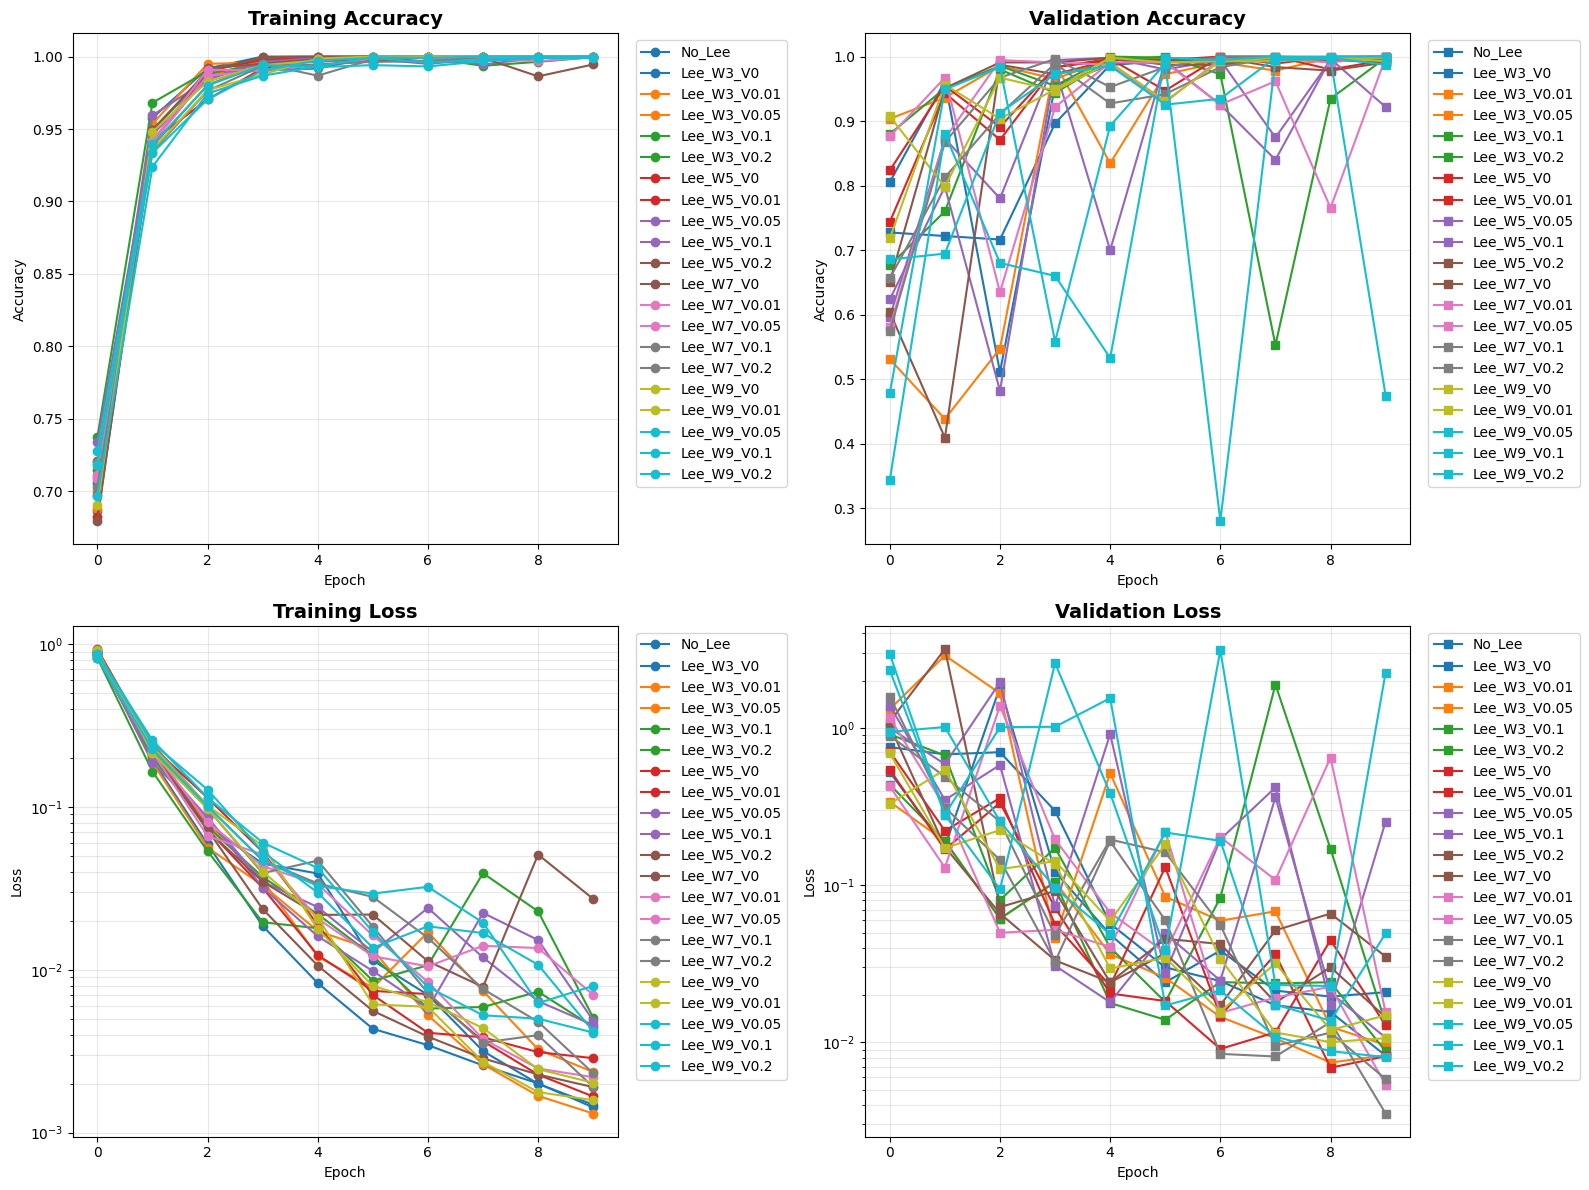


PARAMETRIC STUDY SUMMARY

Configuration             Window   Variance   Val Acc      Test Acc     Time (s)  
------------------------------------------------------------------------------------------
Lee_W9_V0                 9        -          0.9982 (99.8%)  0.9938 (99.4%)  12.53
Lee_W5_V0.01              5        0.01       0.9945 (99.5%)  0.9934 (99.3%)  10.00
Lee_W3_V0                 3        -          0.9909 (99.1%)  0.9926 (99.3%)  5.50
No_Lee                    -        -          0.9982 (99.8%)  0.9918 (99.2%)  5.34
Lee_W5_V0.1               5        0.1        0.9982 (99.8%)  0.9905 (99.1%)  8.35
Lee_W9_V0.1               9        0.1        1.0000 (100.0%)  0.9901 (99.0%)  12.94
Lee_W3_V0.01              3        0.01       1.0000 (100.0%)  0.9897 (99.0%)  5.66
Lee_W3_V0.05              3        0.05       0.9982 (99.8%)  0.9897 (99.0%)  5.65
Lee_W7_V0.2               7        0.2        1.0000 (100.0%)  0.9897 (99.0%)  9.94
Lee_W3_V0.1               3        0.1        

In [19]:
# ============================================================
# PARAMETRIC STUDY RESULTS VISUALIZATION
# ============================================================

print("\n" + "="*70)
print("PARAMETRIC STUDY: TRAINING CURVES COMPARISON")
print("="*70)

# Check if results exist
if not all_results:
    print("\n⚠️  ERROR: No results found!")
    print("Please run the training cell (cell 31) first before running this visualization.")
    print("Make sure NOT to run cell 32 after training, as it resets the results.")
else:
    # Create color palette for different configurations
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Training Accuracy
    ax = axes[0, 0]
    for (config_name, result), color in zip(all_results.items(), colors):
        ax.plot(result['history']['train_acc'], label=config_name, marker='o', color=color)
    ax.set_title('Training Accuracy', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    # Validation Accuracy
    ax = axes[0, 1]
    for (config_name, result), color in zip(all_results.items(), colors):
        ax.plot(result['history']['val_acc'], label=config_name, marker='s', color=color)
    ax.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    # Training Loss
    ax = axes[1, 0]
    for (config_name, result), color in zip(all_results.items(), colors):
        ax.plot(result['history']['train_loss'], label=config_name, marker='o', color=color)
    ax.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(True, alpha=0.3, which='both')

    # Validation Loss
    ax = axes[1, 1]
    for (config_name, result), color in zip(all_results.items(), colors):
        ax.plot(result['history']['val_loss'], label=config_name, marker='s', color=color)
    ax.set_title('Validation Loss', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(True, alpha=0.3, which='both')

    plt.tight_layout()
    plt.show()

    # ============================================================
    # SUMMARY TABLE
    # ============================================================
    print("\n" + "="*90)
    print("PARAMETRIC STUDY SUMMARY")
    print("="*90)
    print(f"\n{'Configuration':<25} {'Window':<8} {'Variance':<10} {'Val Acc':<12} {'Test Acc':<12} {'Time (s)':<10}")
    print("-"*90)

    # Sort by test accuracy
    sorted_results = sorted(all_results.items(), key=lambda x: x[1]['test_acc'], reverse=True)

    for config_name, result in sorted_results:
        ws = result['config']['window_size'] if result['config']['window_size'] else '-'
        nv = result['config']['noise_variance'] if result['config']['noise_variance'] else '-'
        val_acc = result['history']['val_acc'][-1]
        test_acc = result['test_acc']
        train_time = result['total_training_time']
        print(f"{config_name:<25} {str(ws):<8} {str(nv):<10} {val_acc:.4f} ({val_acc*100:.1f}%)  {test_acc:.4f} ({test_acc*100:.1f}%)  {train_time:.2f}")

    print("-"*90)
    best_config = sorted_results[0][0]
    best_acc = sorted_results[0][1]['test_acc']
    print(f"\n🏆 BEST CONFIGURATION: {best_config} with Test Accuracy = {best_acc:.4f} ({best_acc*100:.2f}%)")

## Parametric Study: Heatmaps & Comparison


PARAMETRIC STUDY: HEATMAP VISUALIZATION


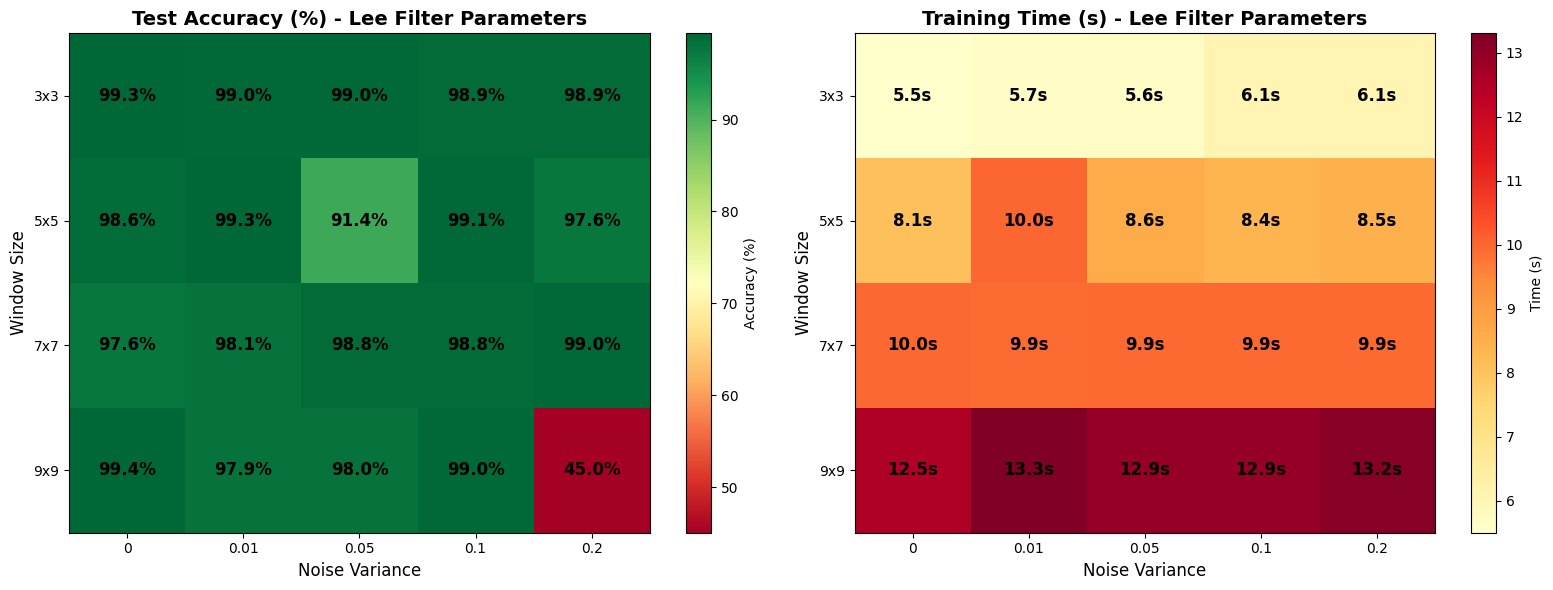

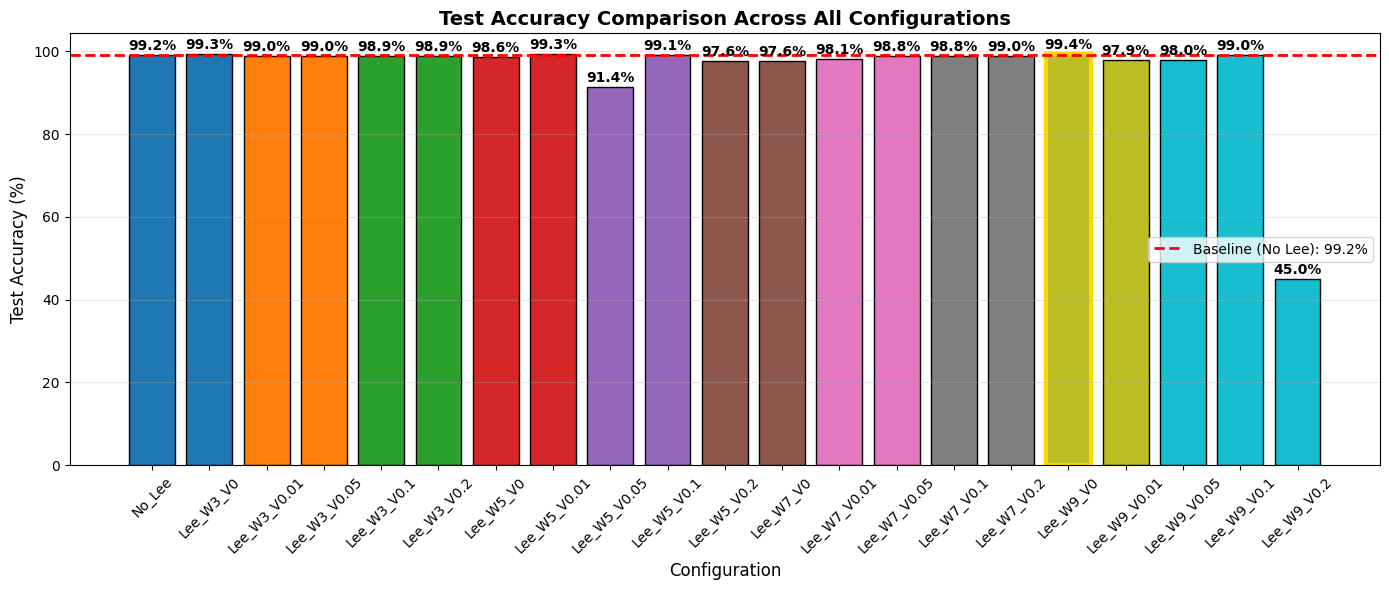

In [20]:
# ============================================================
# HEATMAP: Test Accuracy vs Window Size and Noise Variance
# ============================================================

print("\n" + "="*70)
print("PARAMETRIC STUDY: HEATMAP VISUALIZATION")
print("="*70)

# Extract Lee filter results (exclude no-filter baseline for heatmap)
lee_results = {k: v for k, v in all_results.items() if v['config']['window_size'] is not None}

if len(lee_results) > 0:
    # Get unique values
    window_sizes = sorted(set(v['config']['window_size'] for v in lee_results.values()))
    noise_variances = sorted(set(v['config']['noise_variance'] for v in lee_results.values()))
    
    # Create accuracy matrix
    acc_matrix = np.zeros((len(window_sizes), len(noise_variances)))
    time_matrix = np.zeros((len(window_sizes), len(noise_variances)))
    
    for config_name, result in lee_results.items():
        ws_idx = window_sizes.index(result['config']['window_size'])
        nv_idx = noise_variances.index(result['config']['noise_variance'])
        acc_matrix[ws_idx, nv_idx] = result['test_acc'] * 100
        time_matrix[ws_idx, nv_idx] = result['total_training_time']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Test Accuracy Heatmap
    ax = axes[0]
    im = ax.imshow(acc_matrix, cmap='RdYlGn', aspect='auto')
    ax.set_xticks(range(len(noise_variances)))
    ax.set_xticklabels([f'{nv}' for nv in noise_variances])
    ax.set_yticks(range(len(window_sizes)))
    ax.set_yticklabels([f'{ws}x{ws}' for ws in window_sizes])
    ax.set_xlabel('Noise Variance', fontsize=12)
    ax.set_ylabel('Window Size', fontsize=12)
    ax.set_title('Test Accuracy (%) - Lee Filter Parameters', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(window_sizes)):
        for j in range(len(noise_variances)):
            text = ax.text(j, i, f'{acc_matrix[i, j]:.1f}%', ha='center', va='center', 
                          color='black', fontsize=12, fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Accuracy (%)')
    
    # Training Time Heatmap
    ax = axes[1]
    im2 = ax.imshow(time_matrix, cmap='YlOrRd', aspect='auto')
    ax.set_xticks(range(len(noise_variances)))
    ax.set_xticklabels([f'{nv}' for nv in noise_variances])
    ax.set_yticks(range(len(window_sizes)))
    ax.set_yticklabels([f'{ws}x{ws}' for ws in window_sizes])
    ax.set_xlabel('Noise Variance', fontsize=12)
    ax.set_ylabel('Window Size', fontsize=12)
    ax.set_title('Training Time (s) - Lee Filter Parameters', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(window_sizes)):
        for j in range(len(noise_variances)):
            text = ax.text(j, i, f'{time_matrix[i, j]:.1f}s', ha='center', va='center', 
                          color='black', fontsize=12, fontweight='bold')
    
    plt.colorbar(im2, ax=ax, label='Time (s)')
    
    plt.tight_layout()
    plt.show()
    
    # Bar chart comparing all configurations
    fig, ax = plt.subplots(figsize=(14, 6))
    
    config_names = list(all_results.keys())
    test_accs = [all_results[name]['test_acc'] * 100 for name in config_names]
    
    bars = ax.bar(config_names, test_accs, color=colors[:len(config_names)], edgecolor='black')
    
    # Highlight the best
    best_idx = test_accs.index(max(test_accs))
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)
    
    # Add baseline reference line
    if 'No_Lee' in all_results:
        baseline_acc = all_results['No_Lee']['test_acc'] * 100
        ax.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=2, 
                   label=f'Baseline (No Lee): {baseline_acc:.1f}%')
    
    ax.set_xlabel('Configuration', fontsize=12)
    ax.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax.set_title('Test Accuracy Comparison Across All Configurations', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, acc in zip(bars, test_accs):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                f'{acc:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No Lee filter configurations to visualize in heatmap.")

## Detailed Analysis: Confusion Matrices & Classification Reports


CONFUSION MATRICES: BEST CONFIG vs BASELINE


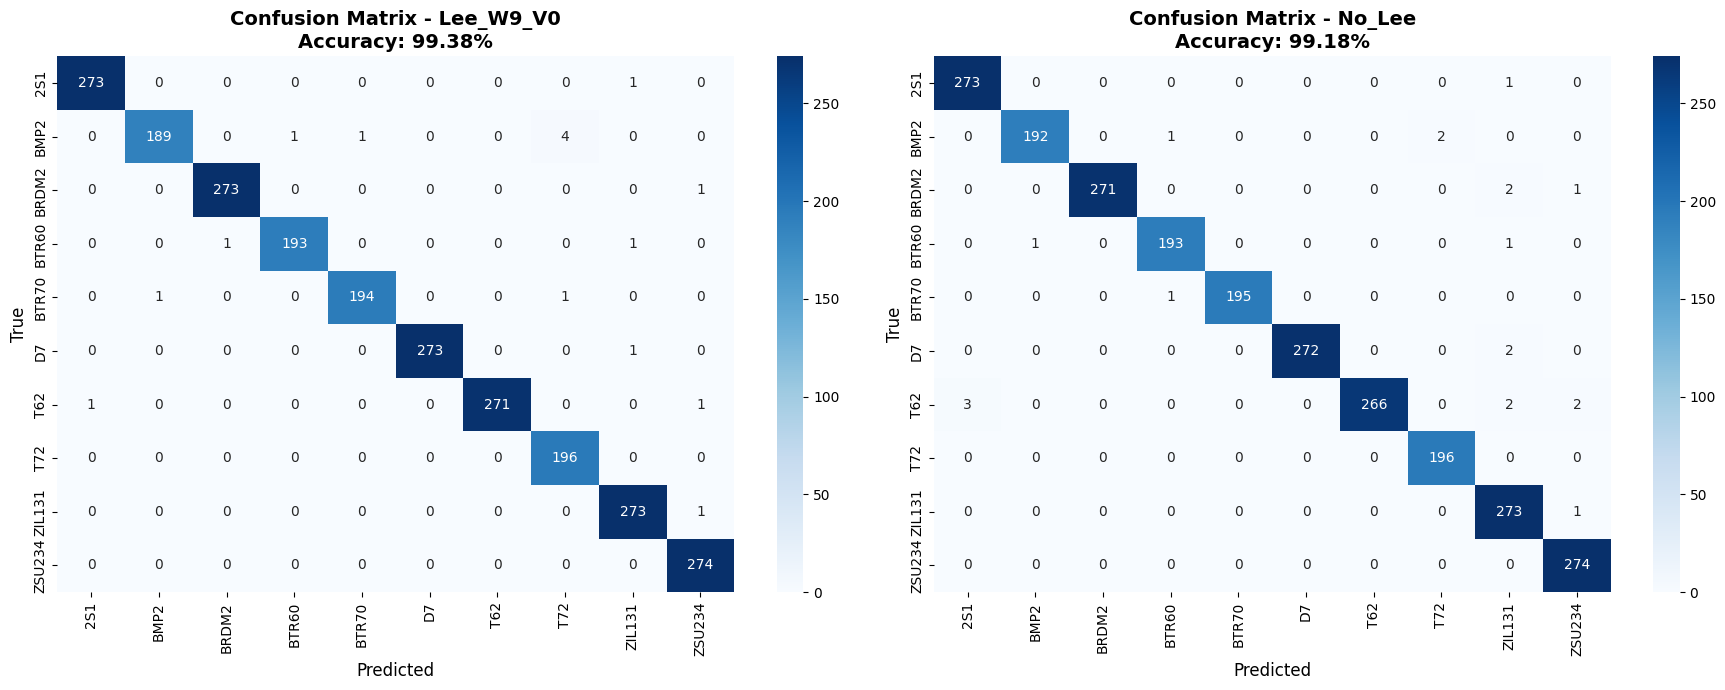


CLASSIFICATION REPORT FOR BEST MODEL: Lee_W9_V0

              precision    recall  f1-score   support

         2S1     0.9964    0.9964    0.9964       274
        BMP2     0.9947    0.9692    0.9818       195
       BRDM2     0.9964    0.9964    0.9964       274
       BTR60     0.9948    0.9897    0.9923       195
       BTR70     0.9949    0.9898    0.9923       196
          D7     1.0000    0.9964    0.9982       274
         T62     1.0000    0.9927    0.9963       273
         T72     0.9751    1.0000    0.9874       196
      ZIL131     0.9891    0.9964    0.9927       274
      ZSU234     0.9892    1.0000    0.9946       274

    accuracy                         0.9934      2425
   macro avg     0.9931    0.9927    0.9928      2425
weighted avg     0.9935    0.9934    0.9934      2425


SAVING PARAMETRIC STUDY RESULTS

Results saved to: /home/alexandre/Documents/PIE Code/ATR-Code/results/parametric_study_lee_filter.json

PARAMETRIC STUDY COMPLETE

Total configurations teste

In [21]:
# ============================================================
# DETAILED ANALYSIS: Confusion Matrices for Best and Baseline
# ============================================================

print("\n" + "="*70)
print("CONFUSION MATRICES: BEST CONFIG vs BASELINE")
print("="*70)

def get_predictions(model, test_loader, device):
    """Get predictions and true labels from a model"""
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# Get best and baseline configurations
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['test_acc'], reverse=True)
best_name, best_result = sorted_results[0]
baseline_name = 'No_Lee' if 'No_Lee' in all_results else sorted_results[-1][0]
baseline_result = all_results[baseline_name]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, (name, result) in zip(axes, [(best_name, best_result), (baseline_name, baseline_result)]):
    y_true, y_pred = get_predictions(result['model'], data_loaders[name]['test_loader'], device)
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(f'Confusion Matrix - {name}\nAccuracy: {result["test_acc"]*100:.2f}%', 
                fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================
# DETAILED CLASSIFICATION REPORT FOR BEST MODEL
# ============================================================

print("\n" + "="*70)
print(f"CLASSIFICATION REPORT FOR BEST MODEL: {best_name}")
print("="*70 + "\n")

y_true, y_pred = get_predictions(best_result['model'], data_loaders[best_name]['test_loader'], device)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# ============================================================
# SAVE RESULTS TO JSON
# ============================================================

print("\n" + "="*70)
print("SAVING PARAMETRIC STUDY RESULTS")
print("="*70)

# Prepare results for JSON (exclude non-serializable objects)
results_for_json = {}
for config_name, result in all_results.items():
    results_for_json[config_name] = {
        'config': result['config'],
        'history': {
            'train_loss': result['history']['train_loss'],
            'train_acc': result['history']['train_acc'],
            'val_loss': result['history']['val_loss'],
            'val_acc': result['history']['val_acc'],
            'epoch_times': result['history']['epoch_times']
        },
        'test_loss': result['test_loss'],
        'test_acc': result['test_acc'],
        'total_training_time': result['total_training_time']
    }

# Save to file
results_path = os.path.join(project_root, 'results', 'parametric_study_lee_filter.json')
os.makedirs(os.path.dirname(results_path), exist_ok=True)
with open(results_path, 'w') as f:
    json.dump(results_for_json, f, indent=2)
print(f"\nResults saved to: {results_path}")

# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "="*70)
print("PARAMETRIC STUDY COMPLETE")
print("="*70)
print(f"\nTotal configurations tested: {len(all_results)}")
print(f"Best configuration: {best_name}")
print(f"Best test accuracy: {best_result['test_acc']*100:.2f}%")

if 'No_Lee' in all_results:
    baseline_acc = all_results['No_Lee']['test_acc']
    improvement = (best_result['test_acc'] - baseline_acc) * 100
    print(f"Improvement over baseline: {improvement:+.2f}%")

In [ ]:
# ============================================================
# VISUAL COMPARISON: Sample with Best Lee Filter vs No Filter
# ============================================================

print("\n" + "="*70)
print("SAMPLE COMPARISON: BEST LEE FILTER VS NO FILTER")
print("="*70)

# Get the best Lee filter configuration (excluding baseline)
lee_configs = [(name, result) for name, result in all_results.items() if name != 'No_Lee']
if lee_configs:
    best_lee_name, best_lee_result = max(lee_configs, key=lambda x: x[1]['test_acc'])
    best_config = best_lee_result['config']
    
    print(f"\nBest Lee Filter Configuration:")
    print(f"  Configuration: {best_lee_name}")
    print(f"  Window Size: {best_config['window_size']}")
    print(f"  Noise Variance: {best_config['noise_variance']}")
    print(f"  Test Accuracy: {best_lee_result['test_acc']*100:.2f}%")
    
    if 'No_Lee' in all_results:
        baseline_acc = all_results['No_Lee']['test_acc']
        improvement = (best_lee_result['test_acc'] - baseline_acc) * 100
        print(f"  Baseline Accuracy: {baseline_acc*100:.2f}%")
        print(f"  Improvement: {improvement:+.2f}%")
    else:
        baseline_acc = None
    
    # Load a sample from test set
    test_dataset_raw = ImageFolder(root=local_test_dir)
    sample_idx = 10  # You can change this to view different samples
    sample_path, sample_label = test_dataset_raw.samples[sample_idx]
    sample_class = class_names[sample_label]
    
    print(f"\nSample Information:")
    print(f"  Index: {sample_idx}")
    print(f"  Class: {sample_class}")
    print(f"  Path: {os.path.basename(sample_path)}")
    
    # Load and process the same image with different filters
    from PIL import Image
    
    # Original image (just loaded and converted to grayscale)
    img_pil = Image.open(sample_path).convert('L')
    
    # Transform without Lee filter
    transform_no_lee = transforms.Compose([
        transforms.CenterCrop(size=CHIP_SIZE),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ])
    
    # Transform with best Lee filter
    transform_best_lee = transforms.Compose([
        transforms.CenterCrop(size=CHIP_SIZE),
        transforms.ToTensor(),
        LeeFilterTransform(window_size=best_config['window_size'], 
                          noise_variance=best_config['noise_variance']),
        transforms.Lambda(lambda x: torch.nn.functional.interpolate(
            x.unsqueeze(0), size=IMAGE_SIZE, mode='bilinear', align_corners=False
        ).squeeze(0))
    ])
    
    # Process both versions
    img_no_lee = transform_no_lee(img_pil).squeeze().numpy()
    img_best_lee = transform_best_lee(img_pil).squeeze().numpy()
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original (no filter)
    im0 = axes[0].imshow(img_no_lee, cmap='gray')
    acc_text = f'No Lee Filter\nClass: {sample_class}'
    if baseline_acc is not None:
        acc_text += f'\nAccuracy: {baseline_acc*100:.2f}%'
    axes[0].set_title(acc_text, fontsize=14, fontweight='bold')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    # Best Lee filter
    im1 = axes[1].imshow(img_best_lee, cmap='gray')
    axes[1].set_title(f'Best Lee Filter (WS={best_config["window_size"]}, NV={best_config["noise_variance"]})\n' + 
                      f'Accuracy: {best_lee_result["test_acc"]*100:.2f}%', 
                      fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Difference (absolute)
    diff = np.abs(img_best_lee - img_no_lee)
    im2 = axes[2].imshow(diff, cmap='hot')
    axes[2].set_title(f'Absolute Difference\nMax Diff: {diff.max():.4f}', 
                     fontsize=14, fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\nImage Statistics:")
    print(f"  No Filter - Mean: {img_no_lee.mean():.4f}, Std: {img_no_lee.std():.4f}")
    print(f"  Best Lee  - Mean: {img_best_lee.mean():.4f}, Std: {img_best_lee.std():.4f}")
    print(f"  Difference - Mean: {diff.mean():.4f}, Max: {diff.max():.4f}")
    
else:
    print("\nNo Lee filter configurations found in results.")